# Определение эмоционального окраса сообщений в чате FINOPOLIS




## 1. Предобработка данных

__Задача__— создать прототип сервиса, который с помощью машинного обучения сможет определять эмоциональный окрас входящих сообщений и классифицировать их по категориям.

Протестировать его работоспособность на открытых данных, используя датасет с отзывами о фильмах, Large Movie Dataset или Sentiment140 от Стэндфордского университета, а также на реальных кейсах, собранных Почта Банком.

Для обучения были выбраны данные, предложенные организаторами, а именно [Sentiment140](http://help.sentiment140.com/for-students/). 



> __Sentiment140__ - размеченный датасет состоящий из твитов, каждый твит имеет эмоциональный окрас: негативный(0), позитивный (4). В контексте задачи кейса, данный датасет является более подходящим, так как текст твитов наиболее приближен к реальному стилю общения человека в различных чатах.






## 1.1. Описательный анализ данных

Предварительно данные были перезаписаны в формат __.parquet__ для более быстрой и простой загрузки данных в GoogleColab, где проводилась вся работа и обучались модели.

In [1]:
# импорт библиотек
import pandas as pd  
import numpy as np

import seaborn as sns
sns.set_style('whitegrid')
sns.set_palette('Set2')

import matplotlib.pyplot as plt

In [2]:
# загрузка данных для обучения
train_data = pd.read_parquet('train.parquet')
train_data.head()

,label,n,date,q,name,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


Описание признаков:

__label__ - the polarity of the tweet (0 = negative,  4 = positive)

__n__ - the id of the tweet (2087)


__date__ - the date of the tweet (Sat May 16 23:58:44 UTC 2009)


__q__ - the query (lyx). If there is no query, then this value is NO_QUERY


__name__ - the user that tweeted (robotickilldozr)


__text__ - the text of the tweet 


In [3]:
# оставим только необходимые для работы данные
train_data = train_data[['label', 'text']]
# приведем метки классов к стандартному виду (0 - negative, 1 - positive)
train_data['label'] = train_data['label'].replace(4,1)

In [4]:
# размер данных для обучения
train_data.shape

(1600000, 2)

In [5]:
# общая информация о типах данных
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 2 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   label   1600000 non-null  int64 
 1   text    1600000 non-null  object
dtypes: int64(1), object(1)
memory usage: 24.4+ MB


In [6]:
# распределение целевой переменной 
train_data['label'].value_counts()

1    800000
0    800000
Name: label, dtype: int64

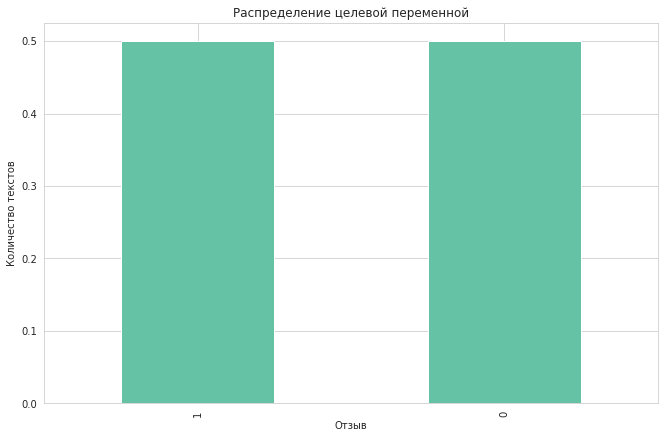

In [7]:
# визуализация распределения целевой переменной
fig = plt.figure(figsize=(11, 7))
train_data['label'].value_counts(normalize=True).plot(kind='bar');
plt.title("Распределение целевой переменной");
plt.xlabel("Отзыв");
plt.ylabel("Количество текстов");

Таким образом, видно, что целевая переменная распределена равномерно, что скажется положительно на обучении модели. Оба класса хорошо сбалансированы. 

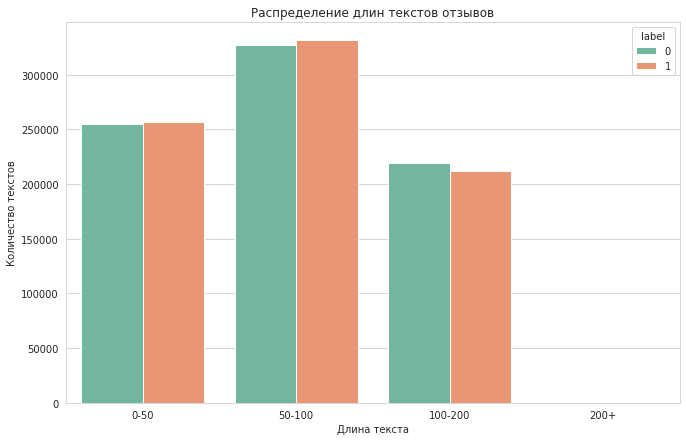

In [8]:
# рассмотрим распределение длин текстов в выборке
df = train_data.copy()
df['length'] = pd.cut(train_data['text'].apply(lambda x: len(x)), bins=[0, 50, 100, 200, float('inf')], 
labels=['0-50', '50-100', '100-200', '200+'])

fig = plt.figure(figsize=(11, 7))
sns.countplot(x='length', hue='label', data=df);
plt.title("Распределение длин текстов отзывов");
plt.xlabel("Длина текста");
plt.ylabel("Количество текстов");

## 1.2. Обработка исходных данных

Заметим, что исходные данные содержат:  

*   различные символы
*   упоминания/отметки пользователей __@user__
*  ссылки __http://__
* остатки декодирования __&,__ __\ufffdn__
* хэши __#...__

Наличие всех перечисленных факторов в текстах может отрицательно влиять на обучение и качество модели, поэтому данные необходимо предобработать и очистить.

In [9]:
import re
from bs4 import BeautifulSoup
from nltk.tokenize import WordPunctTokenizer
tok = WordPunctTokenizer()

In [10]:
 # пример упоминаний, наличия ссылок в тексте
train_data['text'][0]

"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D"

In [11]:
# удаление упоминаний
re.sub(r'@[A-Za-z0-9]+','', train_data['text'][0])

" http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D"

In [12]:
# удаление ссылок
re.sub('https?://[A-Za-z0-9./]+','', train_data['text'][0])

"@switchfoot  - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D"

In [13]:
# функция для предварительной обработки и очистки данных

def text_cleaner(text):

  clean_links = r'https?://[A-Za-z0-9./]+' # очистка от ссылок
  clean_mentions = r'@[A-Za-z0-9]+'  # очистка от упоминаний
  soup = BeautifulSoup(text, 'lxml').get_text() 
  cleaned = re.sub(r'|'.join((clean_links, clean_mentions)), '', soup)

  try:
      cleaned = cleaned.decode("utf-8-sig").replace(u"\ufffd", "?") # очистка от остатков декодирования
  except:
      pass

  final_words = tok.tokenize(re.sub("[^a-zA-Z]", " ", cleaned).lower()) # очистка от хэшей и цифр
  return (" ".join(final_words)).strip()

In [14]:
text_cleaner(train_data['text'][0])

'awww that s a bummer you shoulda got david carr of third day to do it d'

In [15]:
%%time
train_data['cleaned_text'] = train_data['text'].map(lambda x: text_cleaner(x))

CPU times: user 5min 55s, sys: 8.74 s, total: 6min 3s
Wall time: 6min


In [16]:
# очищенные текстовые признаки
train_data['cleaned_text']

0          awww that s a bummer you shoulda got david car...
1          is upset that he can t update his facebook by ...
2          i dived many times for the ball managed to sav...
3             my whole body feels itchy and like its on fire
4          no it s not behaving at all i m mad why am i h...
                                 ...                        
1599995    just woke up having no school is the best feel...
1599996    thewdb com very cool to hear old walt intervie...
1599997    are you ready for your mojo makeover ask me fo...
1599998    happy th birthday to my boo of alll time tupac...
1599999                                 happy charitytuesday
Name: cleaned_text, Length: 1600000, dtype: object

In [17]:
new_train_data = train_data[['label', 'cleaned_text']]
new_train_data.head()

,label,cleaned_text
0,0,awww that s a bummer you shoulda got david car...
1,0,is upset that he can t update his facebook by ...
2,0,i dived many times for the ball managed to sav...
3,0,my whole body feels itchy and like its on fire
4,0,no it s not behaving at all i m mad why am i h...


Запишем очищенные данные, которые впоследствие будем использовать для обучения моделей.

In [18]:
new_train_data.to_parquet('new_train_data.parquet', index=False)